In [25]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END
## the tools are all written separately in tools.py file. 
from lib.tools import add_tool, mul_tool, div_tool, get_stock_price_tool, llm_tool, python_repl_tool 
from lib.prompts import *
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

In [26]:
# ...existing code...
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# Add a simple turn cap
MAX_TURNS = 5
def at_limit(state: MessagesState) -> bool:
    # Count AI turns; stop when limit reached
    return sum(isinstance(m, AIMessage) for m in state["messages"]) >= MAX_TURNS
# ...existing code...

In [27]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [28]:
search_tool = TavilySearchResults()

In [29]:
#agent1
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    if at_limit(state):
        return Command(update={}, goto=END)
    research_agent = create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."), 
    )
          
    result = research_agent.invoke(state)
    result_msg = result["messages"][-1]
    goto = "chart_generator"
    goto = get_next_node(result_msg, goto)
    
    # ✅ Fix the message creation
    updated_msg = HumanMessage(content=result_msg.content, name="researcher")
    
    # ✅ Add the missing return statement
    return Command(update={"messages": result["messages"][:-1] + [updated_msg]}, goto=goto)

In [30]:
#agent2
# ...existing code...
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    if at_limit(state):
        return Command(update={}, goto=END)

    chart_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],  # pass the tool object, don't call it
        prompt=make_system_prompt(
            "You can only generate charts. You are working with a researcher colleague."
        ),
    )

    out = chart_agent.invoke(state)                  # keep the dict
    last = out["messages"][-1]                       # grab last message
    goto = get_next_node(last, "researcher")
    out["messages"][-1] = HumanMessage(              # replace last with named human msg
        content=last.content, name="chart_generator"
    )
    return Command(update={"messages": out["messages"]}, goto=goto)
# ...existing code...

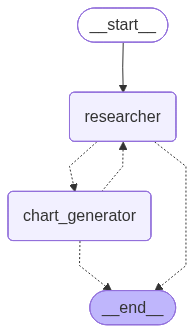

In [31]:
## The loop edges are being created automatically because of the node function declarations where it is explicitly stating the return node method literal. Hence the workflow need not to be created again with the needed edges.
## Network or collaborative multi agent
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_edge(START, "researcher")
app = workflow.compile()
app 

In [32]:
# ...existing code...
# Prefer passing config recursion_limit too
messages = app.invoke(
    {
        "messages": [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it. Once you make the chart, finish.")]
    },
    config={"recursion_limit": 10},
)
for m in messages['messages']:
    m.pretty_print()
# ...existing code...

================================ Human Message =================================

get the UK's GDP over the past 3 years, then make a line chart of it. Once you make the chart, finish.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_iMD7l2UyTEUgFYTqeLg5XiiY)
 Call ID: call_iMD7l2UyTEUgFYTqeLg5XiiY
  Args:
    query: UK GDP data 2020 to 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "U.K. GDP | Historical Chart & Data - Macrotrends", "url": "https://www.macrotrends.net/global-metrics/countries/gbr/united-kingdom/gdp-gross-domestic-product", "content": "## U.K. GDP\n\nPopulation\nEconomy\nTrade\nHealth\nEducation\nDevelopment\nLabor Force\nEnvironment\nCrime\nImmigration\nOther\n\nGDP\nGDP Growth Rate\nGDP Per Capita\nDebt to GDP\nInflation Rate\nManufacturing\nGNI\nGNI Per Capita\nGNP\n\n##### U.K. GDP for 2023 was 3.381 tril